In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [39]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Read in intermediate datasets from 01_data_preparation_and_merging

In [40]:
# merged and minimally prepared/cleaned Billboard Top 100 dataset
df_hits = pd.read_csv('../data/processed/top_hits_features.csv')

# merged and minimally prepared/cleaned non-hit songs dataset
non_hit_tracks = pd.read_csv('../data/processed/non_hit_tracks.csv')

# 4. Feature Distribution Assessment

## 1) Visualizing audio feature and release year distributions for hit songs

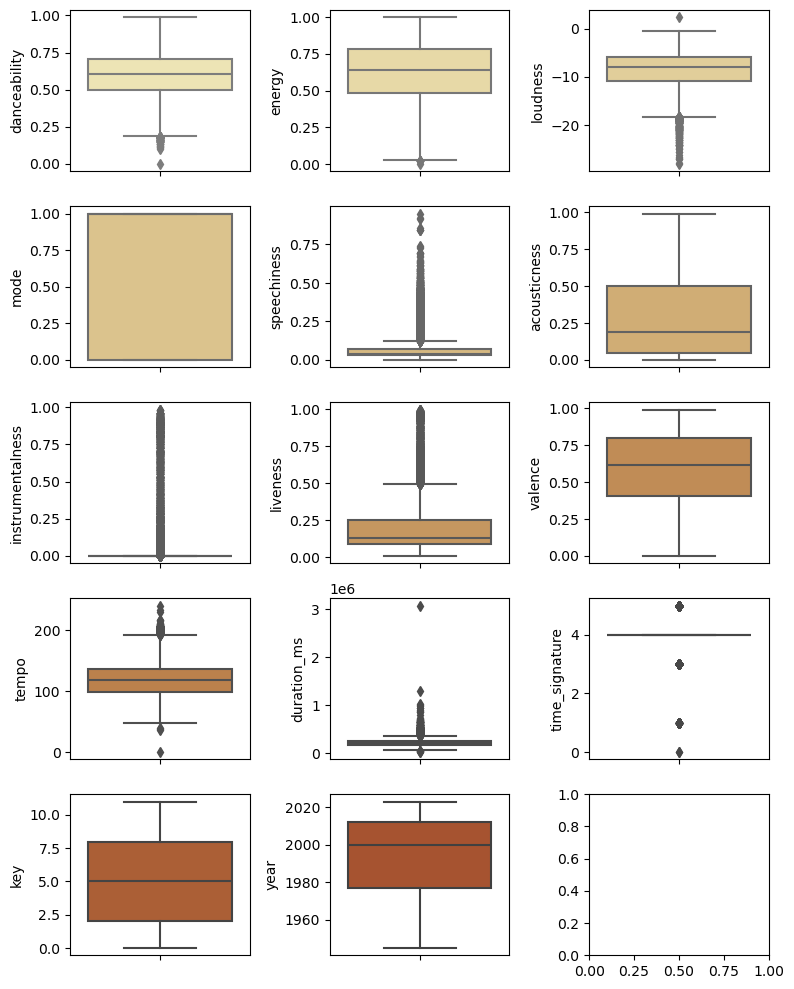

In [41]:
fig, axes = plt.subplots(5,3, figsize=(8,10))

sns.boxplot(df_hits, y="danceability", color='#f7eaab', ax=axes[0,0])
sns.boxplot(df_hits, y="energy", color='#f2df9c', ax=axes[0,1])
sns.boxplot(df_hits, y="loudness", color='#edd38e', ax=axes[0,2])
sns.boxplot(df_hits, y="mode", color='#e8c880',ax=axes[1,0])
sns.boxplot(df_hits, y="speechiness", color='#e3bc73', ax=axes[1,1])
sns.boxplot(df_hits, y="acousticness", color='#dfb066', ax=axes[1,2])
sns.boxplot(df_hits, y="instrumentalness", color='#daa45a', ax=axes[2,0])
sns.boxplot(df_hits, y="liveness", color='#d6984f', ax=axes[2,1])
sns.boxplot(df_hits, y="valence", color='#d28c44', ax=axes[2,2])
sns.boxplot(df_hits, y="tempo", color='#cd803a', ax=axes[3,0])
sns.boxplot(df_hits, y="duration_ms", color='#c97331', ax=axes[3,1])
sns.boxplot(df_hits, y="time_signature", color='#c46629', ax=axes[3,2])
sns.boxplot(df_hits, y="key", color='#bf5922', ax=axes[4,0])
sns.boxplot(df_hits, y="year", color='#ba4b1c', ax=axes[4,1])

fig.tight_layout()

##### Additional view of release year distribution for hit songs

Text(0.5, 1.0, 'distribution of release year - Billboard Top 100 hit song dataset')

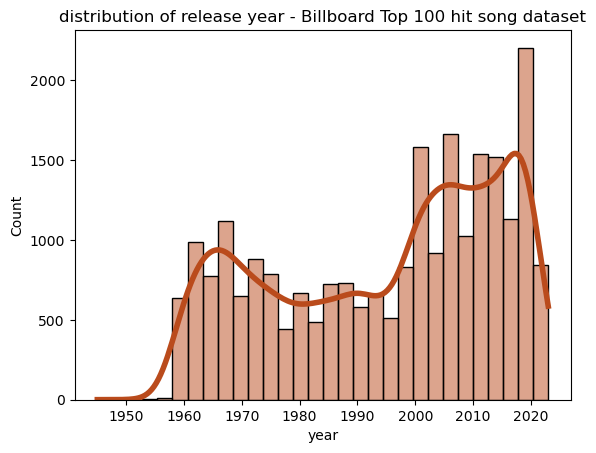

In [42]:
sns.histplot(df_hits['year'], bins=30, kde=True, color='#ba4b1c', alpha=0.5, label='hit songs',
                 line_kws={'color': '#ba4b1c', 'lw': 4})
plt.title('distribution of release year - Billboard Top 100 hit song dataset')

#### Observations:
- Fairly even distribution from ~1960 onward, though there is an overall increase in the number of songs with available audio feature data from ~2000 to 2023
<br>
- Duration seems to have one large outlier at ~17 minutes, will remove outliers based on this field
<br>
- Overall goal will be to remove as few data points as possible from the hit songs as these represent real songs that have made it to the Billboard Top 100. 

## 2) Visualizing audio feature and release year distributions for non-hit songs

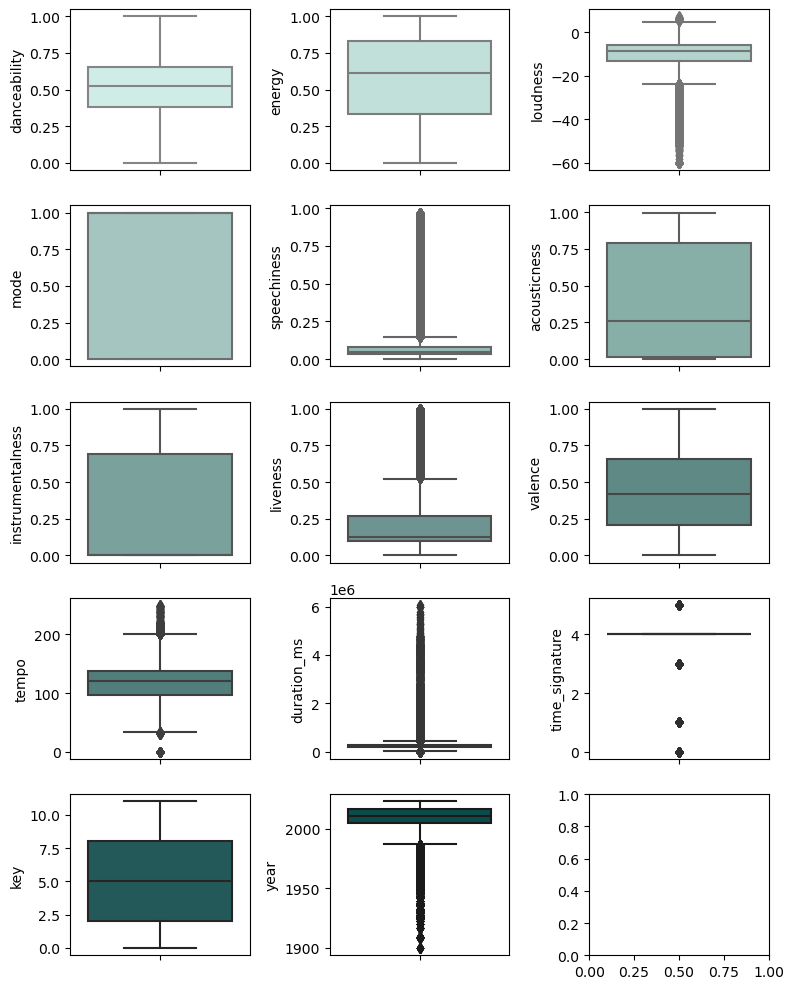

In [43]:
fig, axes = plt.subplots(5,3, figsize=(8,10))

sns.boxplot(non_hit_tracks, y="danceability", color='#caf2e8', ax=axes[0,0])
sns.boxplot(non_hit_tracks, y="energy", color='#bbe5dc', ax=axes[0,1])
sns.boxplot(non_hit_tracks, y="loudness", color='#add9d0', ax=axes[0,2])
sns.boxplot(non_hit_tracks, y="mode", color='#9fccc4',ax=axes[1,0])
sns.boxplot(non_hit_tracks, y="speechiness", color='#90c0b8', ax=axes[1,1])
sns.boxplot(non_hit_tracks, y="acousticness", color='#82b4ac', ax=axes[1,2])
sns.boxplot(non_hit_tracks, y="instrumentalness", color='#74a7a1', ax=axes[2,0])
sns.boxplot(non_hit_tracks, y="liveness", color='#669b96', ax=axes[2,1])
sns.boxplot(non_hit_tracks, y="valence", color='#58908b', ax=axes[2,2])
sns.boxplot(non_hit_tracks, y="tempo", color='#4a8480', ax=axes[3,0])
sns.boxplot(non_hit_tracks, y="duration_ms", color='#3b7875', ax=axes[3,1])
sns.boxplot(non_hit_tracks, y="time_signature", color='#2c6d6b', ax=axes[3,2])
sns.boxplot(non_hit_tracks, y="key", color='#1a6261', ax=axes[4,0])
sns.boxplot(non_hit_tracks, y="year", color='#005757', ax=axes[4,1])

fig.tight_layout()

Text(0.5, 1.0, 'distribution of release year - 2.3 million song dataset')

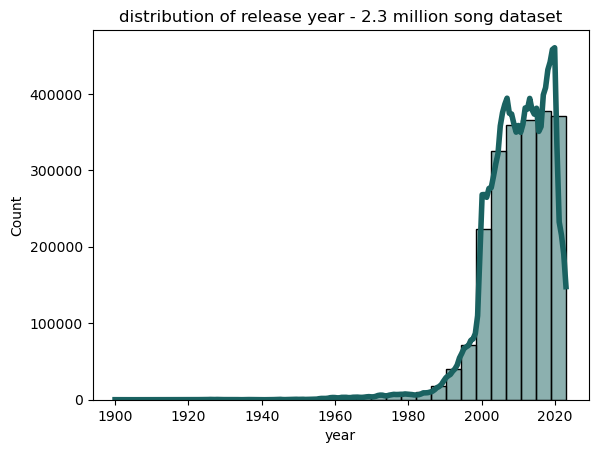

In [44]:
sns.histplot(non_hit_tracks['year'], bins=30, kde=True, color= '#1a6261', alpha=0.5, label='non-hit songs',
                 line_kws={'color': '#1a6261', 'lw': 4})
plt.title('distribution of release year - 2.3 million song dataset')

#### Observations:
- Highly skewed distribution of non-hit song release year, favoring > 2000 songs. 
<br>
- Duration has a very large and significant outlier population with the longest song being ~ 100 minutes. This requires further evaluation.
<br>
- Overall goal will be to handle outliers for song duration (duration_ms) and employ stratified random sampling to handle skewed release year distribution
<br>
- Random samplig will also be needed to create a final dataset of 50% hit songs and 50% non-hit songs

# 5. Handling Outliers

### Song Release Year (year)
A lower year limit of 1985 will be set for both datasets due to the skewed distribution of the 2 million songs dataset.
<br>
Along with stratified random sampling, this will alleviate any biases due to skewed release year distribution between the hit and non-hit songs

In [45]:
# remove songs released prior to 1985 from hit songs dataset
df_hits_cleaned = df_hits[df_hits['year'] >= 1985]
print(len(df_hits))
print(len(df_hits_cleaned))

23925
16242


In [46]:
# Check the year range of the hit songs (1985-2023)
df_hits_cleaned.describe().loc[['min', 'max']]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,hit_song
min,0.101,0.0223,0.0,-23.883,0.0,0.0219,0.000003,0.000,0.00967,0.0349,50.374,29688.0,0.0,1985.0,1.0
max,0.986,0.9970,11.0,-0.463,1.0,0.9510,0.990000,0.985,0.99600,0.9890,231.028,3079157.0,5.0,2023.0,1.0


In [47]:
# remove songs released prior to 1985 from non-hit songs dataset
non_hit_filtered = non_hit_tracks[non_hit_tracks['year'] >= 1985]
print(len(non_hit_tracks))
print(len(non_hit_filtered))

2191269
2156335


In [48]:
# Check the year range of the non-hit songs (1985-2023)
non_hit_filtered.describe().loc[['min', 'max']]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,hit_song
min,0.0,0.0,0.0,-60.000,0.0,0.000,0.000,0.0,0.0,0.0,0.000,1000.0,0.0,1985.0,0.0
max,1.0,1.0,11.0,7.234,1.0,0.971,0.996,1.0,1.0,1.0,249.993,6061090.0,5.0,2023.0,0.0


### Song Duration (duration_ms)
Remove songs from non-hits dataset with song lengths outside of the range defined by the hit songs dataset. As this range is quite large (up to ~17 minutes), this should filter only extreme outliers from the dataset

In [49]:
# setting apper and lower bounds for duration based on hit songs distribution
lower_bound = df_hits_cleaned['duration_ms'].describe()['min']
upper_bound = df_hits_cleaned['duration_ms'].describe()['max']

print(lower_bound,';', upper_bound)

29688.0 ; 3079157.0


In [50]:
# filtering out extreme duration outliers from non-hit songs
non_hit_cleaned = non_hit_filtered[(non_hit_filtered['duration_ms'] >= lower_bound) & 
                                   (non_hit_filtered['duration_ms'] <= upper_bound)]

# Print the number of rows before and after removing outliers
print(f"Number of rows before removing outliers: {len(non_hit_filtered)}")
print(f"Number of rows after removing outliers: {len(non_hit_cleaned)}")

Number of rows before removing outliers: 2156335
Number of rows after removing outliers: 2146867


In [51]:
non_hit_cleaned.describe().loc[['min', 'max']]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,hit_song
min,0.0,0.0,0.0,-60.000,0.0,0.000,0.000,0.0,0.0,0.0,0.000,29690.0,0.0,1985.0,0.0
max,1.0,1.0,11.0,7.234,1.0,0.971,0.996,1.0,1.0,1.0,249.993,3078005.0,5.0,2023.0,0.0


# 6. Stratified Random Sampling of Non-Hit Songs
#### *Our goal is to ensure that the impact of release year in our classification modeling is not skewed by an imbalance in our dataset.*

### 1) Distribution of song release years across the hits and non-hits datasets

Text(0.5, 1.0, 'Distribution of Release Year - Billboard Hit Songs')

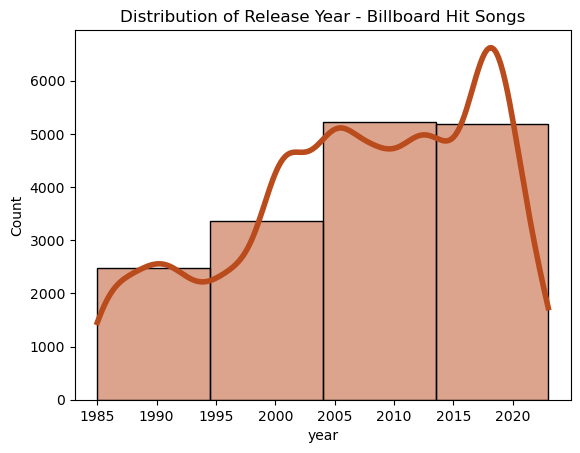

In [52]:
sns.histplot(df_hits_cleaned['year'], bins=4, kde=True, color='#ba4b1c', alpha=0.5, label='hit songs',
                 line_kws={'color': '#ba4b1c', 'lw': 4})
plt.title('Distribution of Release Year - Billboard Hit Songs')

Text(0.5, 1.0, 'Distribution of Release Year - Non-Hit Songs')

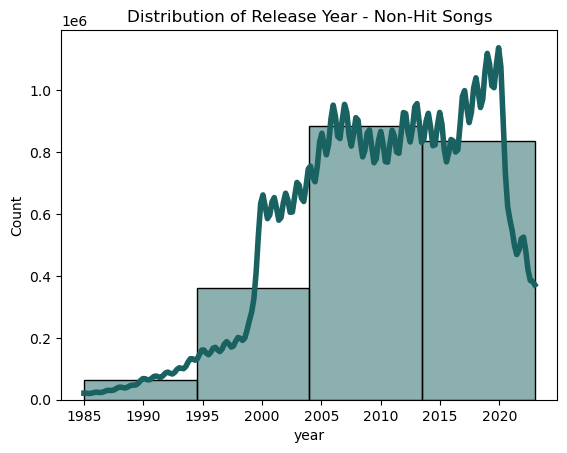

In [53]:
sns.histplot(non_hit_cleaned['year'], bins=4, kde=True, color='#1a6261', alpha=0.5, label='hit songs',
                 line_kws={'color': '#1a6261', 'lw': 4})
plt.title('Distribution of Release Year - Non-Hit Songs')

### 2) Random stratified sampling: select 16,242 non-hit songs following the release year distribution of the hit songs

In [54]:
hits_1985_1994 = df_hits_cleaned[(df_hits_cleaned['year'] >= 1985) & (df_hits_cleaned['year'] <= 1994)]
hits_1995_2004 = df_hits_cleaned[(df_hits_cleaned['year'] >= 1995) & (df_hits_cleaned['year'] <= 2004)]
hits_2005_2014 = df_hits_cleaned[(df_hits_cleaned['year'] >= 2005) & (df_hits_cleaned['year'] <= 2014)]
hits_2015_2023 = df_hits_cleaned[(df_hits_cleaned['year'] >= 2015) & (df_hits_cleaned['year'] <= 2023)]

total_songs = len(df_hits_cleaned)

percentage_hits_1985_1994 = (len(hits_1985_1994) / total_songs) * 100
percentage_hits_1995_2004 = (len(hits_1995_2004) / total_songs) * 100
percentage_hits_2005_2014 = (len(hits_2005_2014) / total_songs) * 100
percentage_hits_2015_2023 = (len(hits_2015_2023) / total_songs) * 100

print(f"Percentage of songs between 1985 and 1994 in df_hits_cleaned: {percentage_hits_1985_1994:.2f}%")
print(f"Percentage of songs between 1995 and 2024 in df_hits_cleaned: {percentage_hits_1995_2004:.2f}%")
print(f"Percentage of songs between 2005 and 2014 in df_hits_cleaned: {percentage_hits_2005_2014:.2f}%")
print(f"Percentage of songs between 2015 and 2023 in df_hits_cleaned: {percentage_hits_2015_2023:.2f}%")

Percentage of songs between 1985 and 1994 in df_hits_cleaned: 15.22%
Percentage of songs between 1995 and 2024 in df_hits_cleaned: 23.68%
Percentage of songs between 2005 and 2014 in df_hits_cleaned: 32.47%
Percentage of songs between 2015 and 2023 in df_hits_cleaned: 28.64%


In [55]:
# calculate the number of songs to sample from each bin of years based on stratified sampling
num_songs_1985_1994 = round(percentage_hits_1985_1994 * len(df_hits_cleaned))/100
num_songs_1995_2004 = round(percentage_hits_1995_2004 * len(df_hits_cleaned))/100
num_songs_2005_2014 = round(percentage_hits_2005_2014 * len(df_hits_cleaned))/100
num_songs_2015_2023 = round(percentage_hits_2015_2023 * len(df_hits_cleaned))/100

print("1985-1994 songs count:", num_songs_1985_1994)
print("1995-2004 songs count:", num_songs_1995_2004)
print("2005-2014 songs count:", num_songs_2005_2014)
print("2015-2023 songs count:", num_songs_2015_2023)
print("Total songs count:", num_songs_1985_1994 + num_songs_1995_2004 + num_songs_2005_2014 + num_songs_2015_2023)
print("Hit songs count:", len(df_hits_cleaned))

1985-1994 songs count: 2472.0
1995-2004 songs count: 3846.0
2005-2014 songs count: 5273.0
2015-2023 songs count: 4651.0
Total songs count: 16242.0
Hit songs count: 16242


#### Random stratified sampling by bin (range of release year)

In [56]:
# Random Stratified Sampling
    # Sample 2409 non-hits between 1985 and 1994
non_hits_1985_1994 = non_hit_cleaned[(non_hit_cleaned['year'] >= 1985) & (non_hit_cleaned['year'] <= 1994)]
rand_1985_1994 = non_hits_1985_1994.sample(n=2472, random_state=42)
print(len(rand_1985_1994))
    # Sample 3747 non-hits between 1995 and 2004
non_hits_1995_2004 = non_hit_cleaned[(non_hit_cleaned['year'] >= 1995) & (non_hit_cleaned['year'] <= 2004)]
rand_1995_2004 = non_hits_1995_2004.sample(n=3846, random_state=42)
print(len(rand_1995_2004))
    # Sample 5137 non-hits between 2005 and 2014
non_hits_2005_2014 = non_hit_cleaned[(non_hit_cleaned['year'] >= 2005) & (non_hit_cleaned['year'] <= 2014)]
rand_2005_2014 = non_hits_2005_2014.sample(n=5273, random_state=42)
print(len(rand_2005_2014))
    # Sample 4531 non-hits between 2015 and 2023
non_hits_2015_2023 = non_hit_cleaned[(non_hit_cleaned['year'] >= 2015) & (non_hit_cleaned['year'] <= 2023)]
rand_2015_2023 = non_hits_2015_2023.sample(n=4651, random_state=42)
print(len(rand_2015_2023))

print(len(rand_1985_1994) + len(rand_1995_2004) + len(rand_2005_2014) + len(rand_2015_2023))

2472
3846
5273
4651
16242


In [57]:
# Combine the binned datasets to create a 16k non-hits dataset
non_hits_16k = pd.concat([rand_1985_1994, rand_1995_2004, rand_2005_2014, rand_2015_2023])

Text(0.5, 1.0, 'distribution of release year - stratified subset from 2 million song dataset')

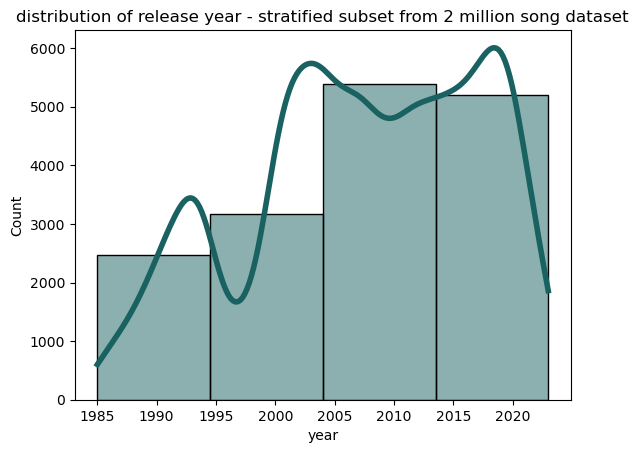

In [58]:
sns.histplot(non_hits_16k['year'], bins=4, kde=True, color= '#1a6261', alpha=0.5, label='non-hit songs',
                 line_kws={'color': '#1a6261', 'lw': 4})
plt.title('distribution of release year - stratified subset from 2 million song dataset')

## Creation of intermediate datasets:
- df_hits_cleaned: hit songs dataset with lower bound of release year at 1985 (~16,000 songs total)
- non_hits_16k: non-hit songs dataset with lower bound of release year at 1985, extreme song duration outliers removed to match hit song distribution, stratified random sampling of release year by bin to match distribution and dataset size of hit songs

In [59]:
df_hits_cleaned.head()

,song,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,song_artist,hit_song
0,guerrilla radio,rage against the machine,0.599,0.957,11.0,-5.764,1.0,0.1880,0.012900,0.000071,0.155,0.489,103.680,206200.0,4.0,1999,guerrilla radio_rage against the machine,1
1,leave right now,will young,0.641,0.445,6.0,-8.674,1.0,0.0368,0.145000,0.000000,0.108,0.383,81.931,214733.0,4.0,2003,leave right now_will young,1
2,let the day begin,the call,0.428,0.867,2.0,-5.051,1.0,0.0818,0.024100,0.025300,0.715,0.383,124.154,265744.0,4.0,2000,let the day begin_the call,1
3,misery,soul asylum,0.380,0.643,0.0,-8.304,1.0,0.0287,0.000049,0.000027,0.244,0.297,113.674,264360.0,4.0,1995,misery_soul asylum,1
4,promises broken,soul asylum,0.472,0.475,4.0,-11.115,1.0,0.0311,0.138000,0.000003,0.113,0.718,150.611,194587.0,4.0,1995,promises broken_soul asylum,1


In [61]:
df_hits_cleaned.to_csv('../data/processed/df_hits_cleaned.csv', index=False)

In [62]:
non_hits_16k.to_csv('../data/processed/non_hits_sampled.csv', index=False)